Vamos a hacer un Clustering jerárquico, para una temporada

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def preparar_datos_para_clustering(df, columnas_excluir=None, divisor=38):
    """
    Prepara un DataFrame para clustering jerárquico:
    - Filtra numéricas
    - Divide por un divisor (por defecto 38) Adaptar a la bundesliga
    - Aplica StandardScaler

    Parámetros:
    - df: DataFrame original
    - columnas_excluir: lista de columnas a mantener fuera (ID, etiquetas)
    - divisor: valor para normalizar (por defecto 38 partidos)

    Retorna:
    - df_escalado: array numpy listo para clustering
    - df_filtrado: DataFrame escalado con índice original
    """
    if columnas_excluir is None:
        columnas_excluir = []

    # Separar columnas excluidas
    df_excluir = df[columnas_excluir] if columnas_excluir else pd.DataFrame(index=df.index)

    # Seleccionar solo numéricas no excluidas
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns=columnas_excluir, errors='ignore')

    # Normalizar por divisor (por partido o por 90 minutos)
    df_normalizado = df_numeric / divisor

    # Escalar
    scaler = StandardScaler()
    df_escalado = scaler.fit_transform(df_normalizado)

    # Convertimos a DataFrame si quieres conservar estructura
    df_escalado_df = pd.DataFrame(df_escalado, index=df.index, columns=df_normalizado.columns)

    return df_escalado, df_escalado_df, df_normalizado


In [2]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

def dendograma_jerarquico(X, metodo='ward', titulo='Dendograma jerárquico'):
    """
    Genera un dendrograma jerárquico
    - X: datos escalados
    - metodo: método de linkage (ward, complete, average, etc.)
    """
    plt.figure(figsize=(14, 6))
    linkage_matrix = sch.linkage(X, method=metodo)
    sch.dendrogram(linkage_matrix)
    plt.title(titulo)
    plt.xlabel('Observaciones')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()


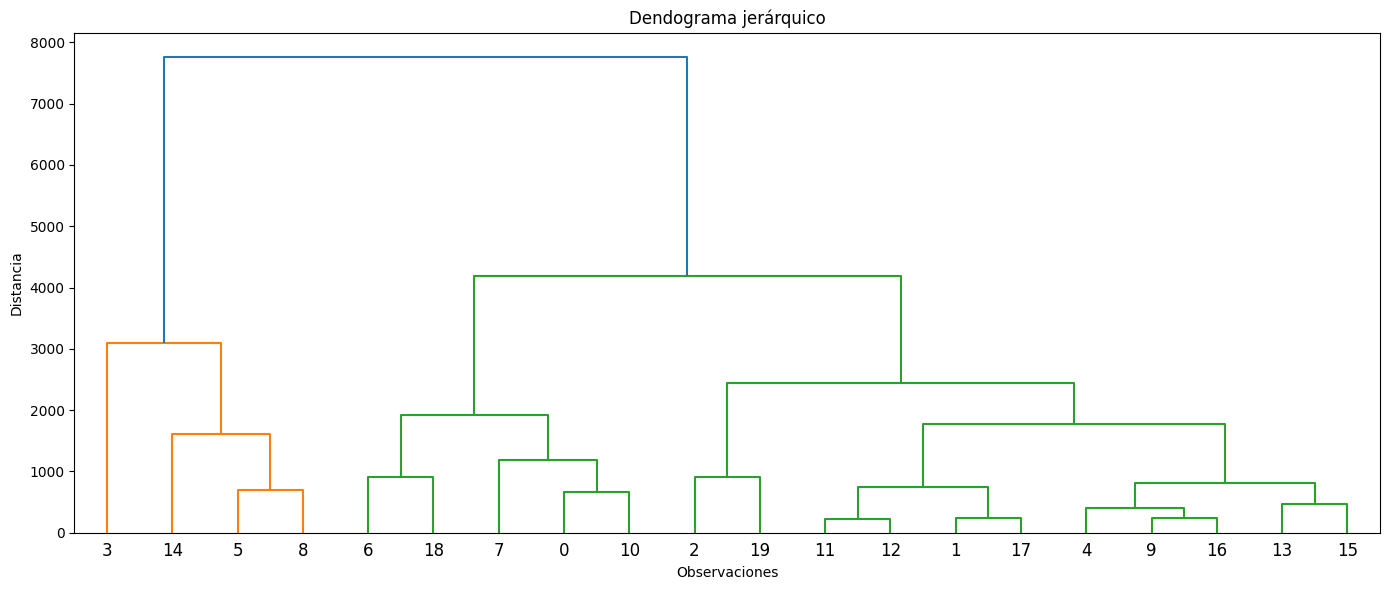

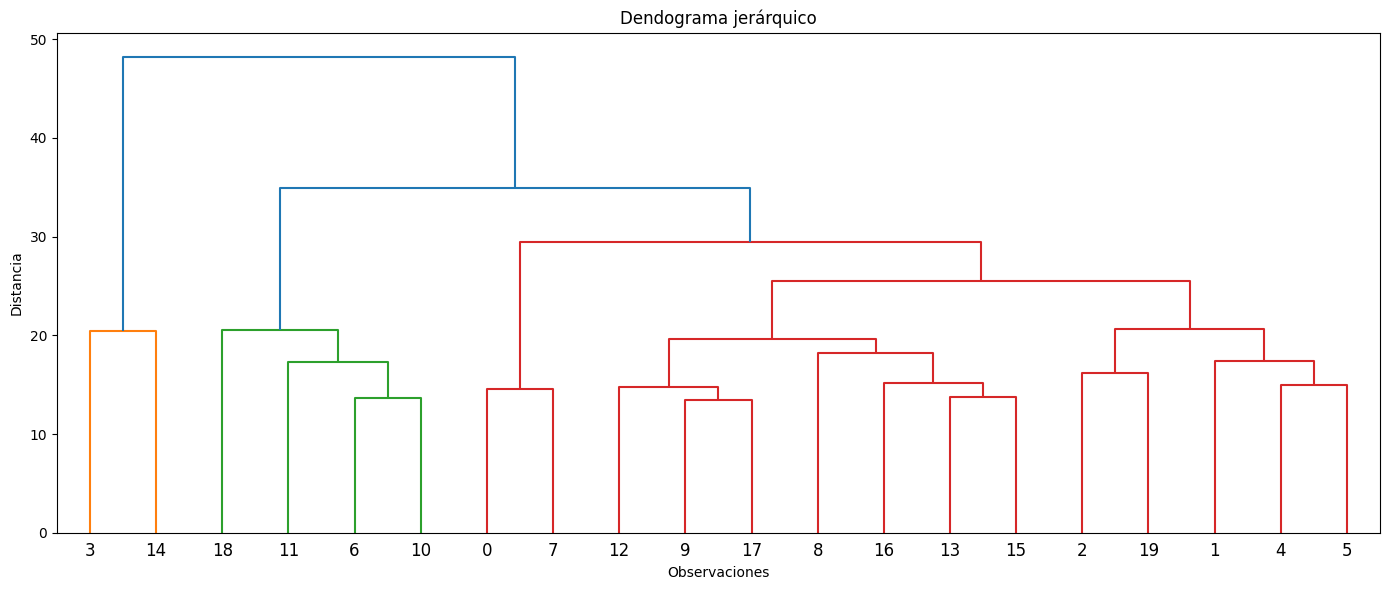

In [3]:
# Cargar datos
df = pd.read_csv("../output/all_teams_all_metrics.csv")
df = df[df['Season'] == '2024-2025']  # Filtrar por temporada específica
# Preprocesar (excluyendo columnas no numéricas o IDs)
X, df_ready, X_90 = preparar_datos_para_clustering(df, columnas_excluir=["Squad", "Season"])

# Mostrar dendrograma
dendograma_jerarquico(X_90)
dendograma_jerarquico(X)

Añadimos nombre y temporada para cada equipo, buscando así una mejor identificación.

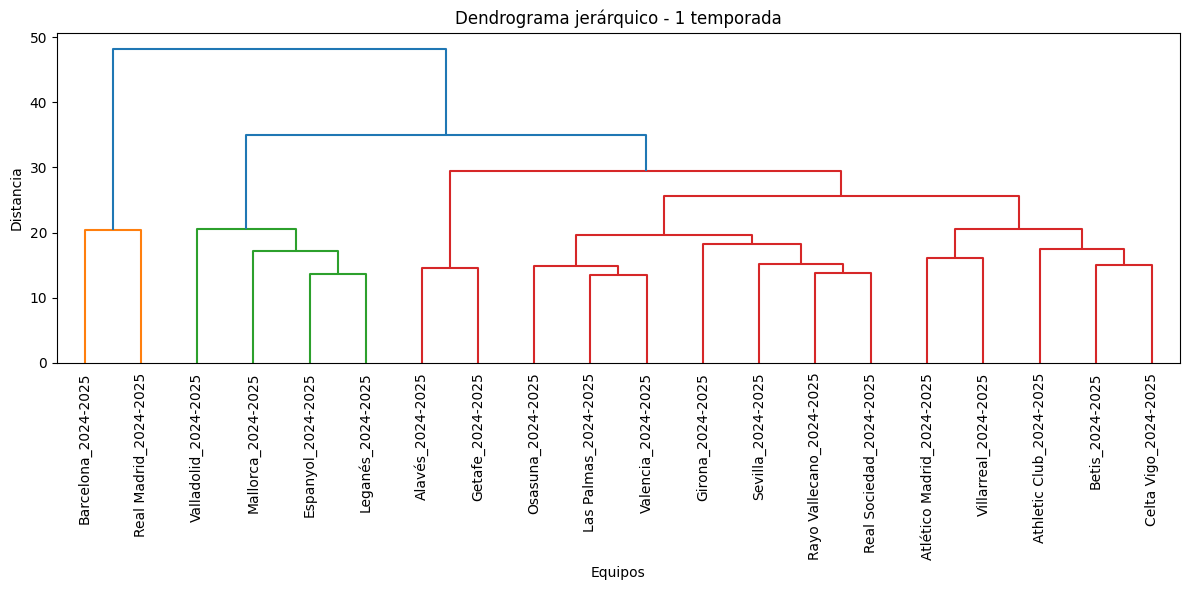

In [4]:

df["Equipo_Temporada"] = df["Squad"] + "_" + df["Season"].astype(str)
plt.figure(figsize=(12, 6))
linkage_matrix = sch.linkage(X, method='ward')

sch.dendrogram(
    linkage_matrix,
    labels=df["Equipo_Temporada"].tolist(),
    leaf_rotation=90,
    leaf_font_size=10
)

plt.title("Dendrograma jerárquico - 1 temporada")
plt.xlabel("Equipos")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()



*Veamos el Silhouette Score*

De esta forma veremos el número de clústeres óptimo

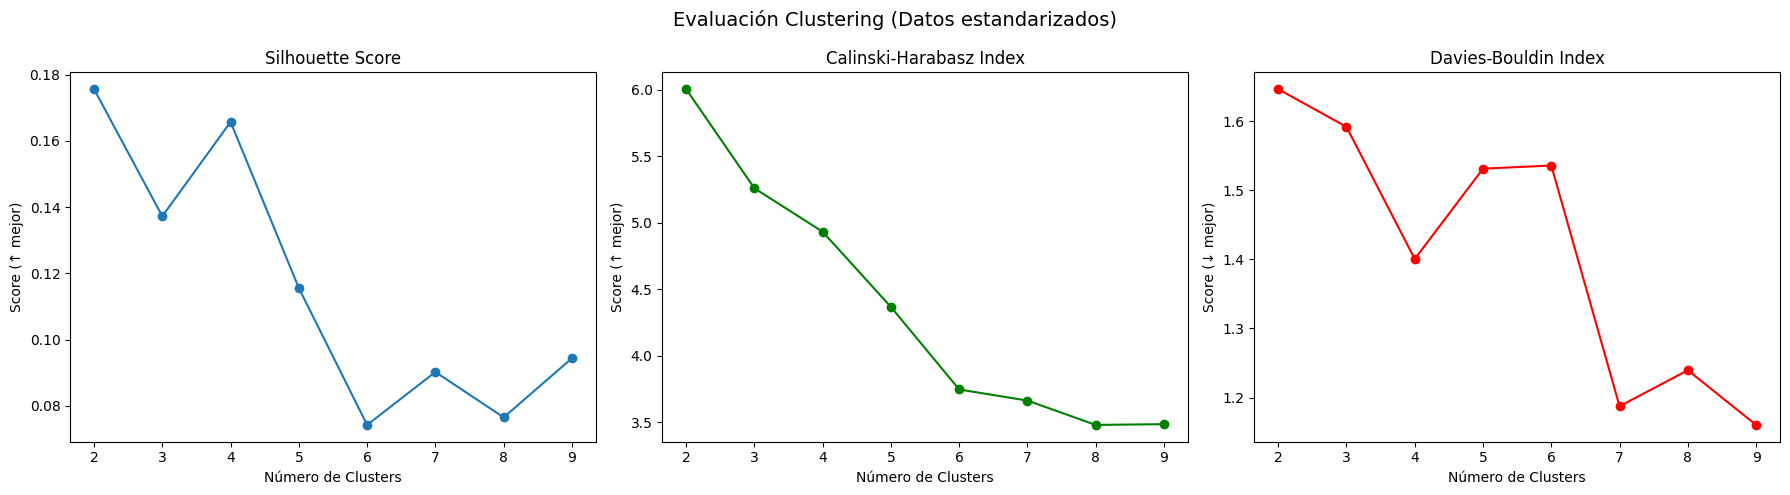

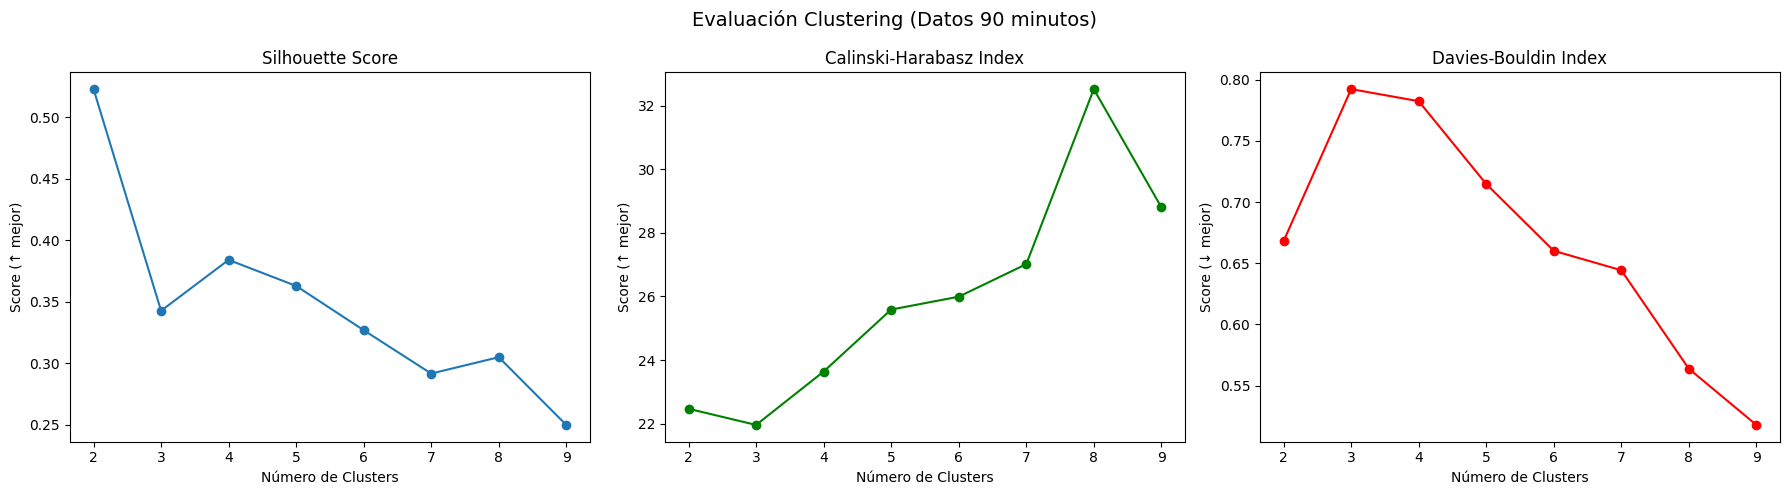

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

def evaluar_clusters(X, rango=range(2, 10), titulo="Evaluación de Clustering"):
    silhouette_scores = []
    calinski_scores = []
    davies_scores = []

    for k in rango:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        silhouette_scores.append(silhouette_score(X, labels))
        calinski_scores.append(calinski_harabasz_score(X, labels))
        davies_scores.append(davies_bouldin_score(X, labels))

    # Graficar resultados
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(rango, silhouette_scores, marker='o')
    axes[0].set_title("Silhouette Score")
    axes[0].set_xlabel("Número de Clusters")
    axes[0].set_ylabel("Score (↑ mejor)")

    axes[1].plot(rango, calinski_scores, marker='o', color='green')
    axes[1].set_title("Calinski-Harabasz Index")
    axes[1].set_xlabel("Número de Clusters")
    axes[1].set_ylabel("Score (↑ mejor)")

    axes[2].plot(rango, davies_scores, marker='o', color='red')
    axes[2].set_title("Davies-Bouldin Index")
    axes[2].set_xlabel("Número de Clusters")
    axes[2].set_ylabel("Score (↓ mejor)")

    fig.suptitle(titulo, fontsize=14)
    plt.tight_layout()
    plt.show()

    return {
        "Silhouette": silhouette_scores,
        "Calinski-Harabasz": calinski_scores,
        "Davies-Bouldin": davies_scores
    }

# Ejemplo con tus datos estandarizados
resultados_std = evaluar_clusters(X, rango=range(2,10), titulo="Evaluación Clustering (Datos estandarizados)")

# Ejemplo con datos normalizados por 90 minutos
resultados_90 = evaluar_clusters(X_90, rango=range(2,10), titulo="Evaluación Clustering (Datos 90 minutos)")


**Observaciones**

Vemos que el valor más óptimo para el número de clústeres, con los datos estandarizados sería 4, ya que es el que obtiene mejor puntuación media en los 3 test que realizamos.

Para los datos por 90 minutos, tenemos mejores valores en todas los tests observando así que usar estas métricas son más interesantes que usarlas todas estandarizadas.

In [6]:
from scipy.cluster.hierarchy import fcluster, linkage

# Calcular linkage con el mismo método que en el dendrograma
linkage_matrix = linkage(X, method="ward")

# Asignar clusters (por número de clusters)
n_clusters = 4  # ajusta según veas en el dendrograma
clusters = fcluster(linkage_matrix, n_clusters, criterion="maxclust")

# Añadir al DataFrame escalado
df_ready["Cluster"] = clusters
df_ready["Squad"] = df["Squad"].values  # Recuperamos nombre de equipo


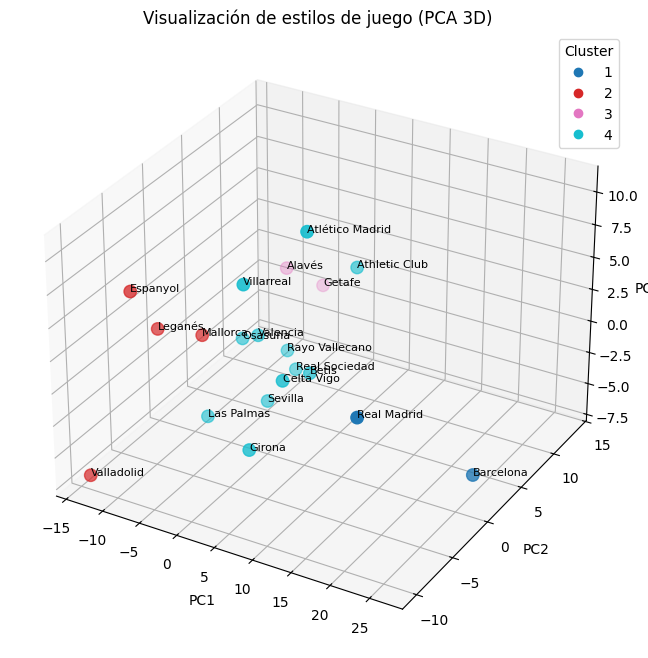

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import pandas as pd

pca3d = PCA(n_components=3)
X_pca3d = pca3d.fit_transform(X)

df_pca3d = pd.DataFrame(X_pca3d, columns=["PC1", "PC2", "PC3"], index=df.index)
df_pca3d["Cluster"] = clusters
df_pca3d["Squad"] = df["Squad"].values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca3d["PC1"], df_pca3d["PC2"], df_pca3d["PC3"],
                     c=df_pca3d["Cluster"], cmap="tab10", s=80)

for i, row in df_pca3d.iterrows():
    ax.text(row["PC1"], row["PC2"], row["PC3"], row["Squad"], fontsize=8)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Visualización de estilos de juego (PCA 3D)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


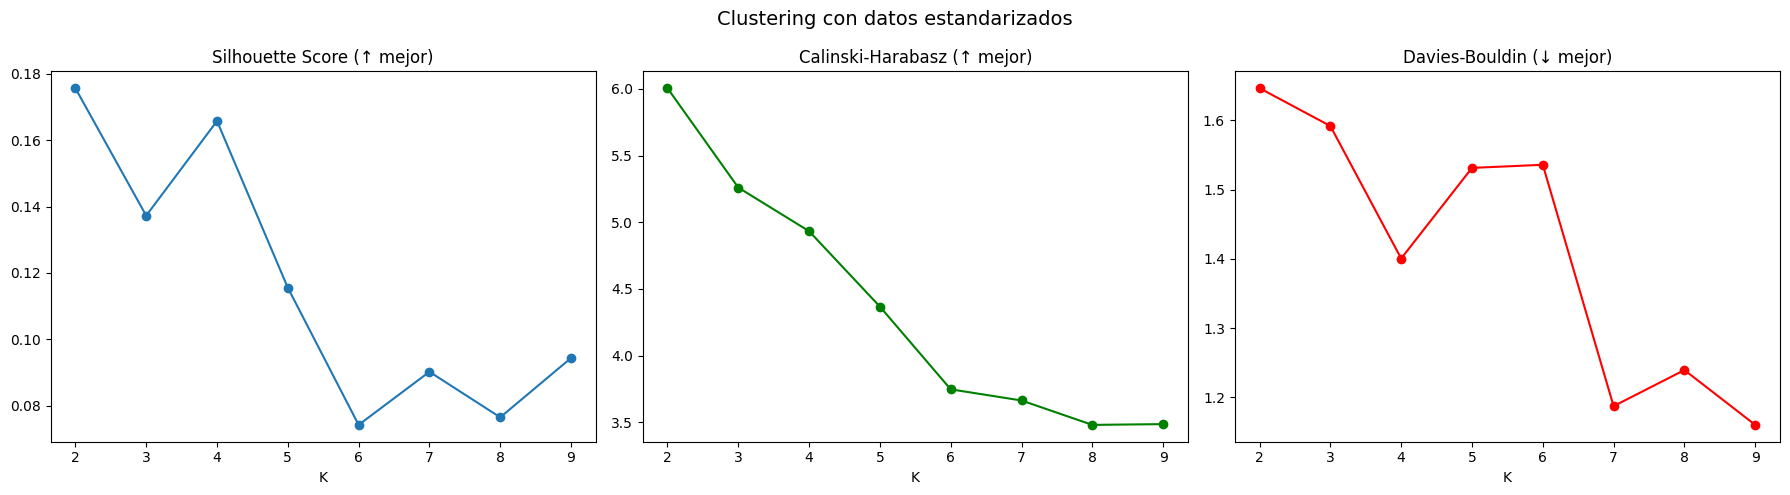

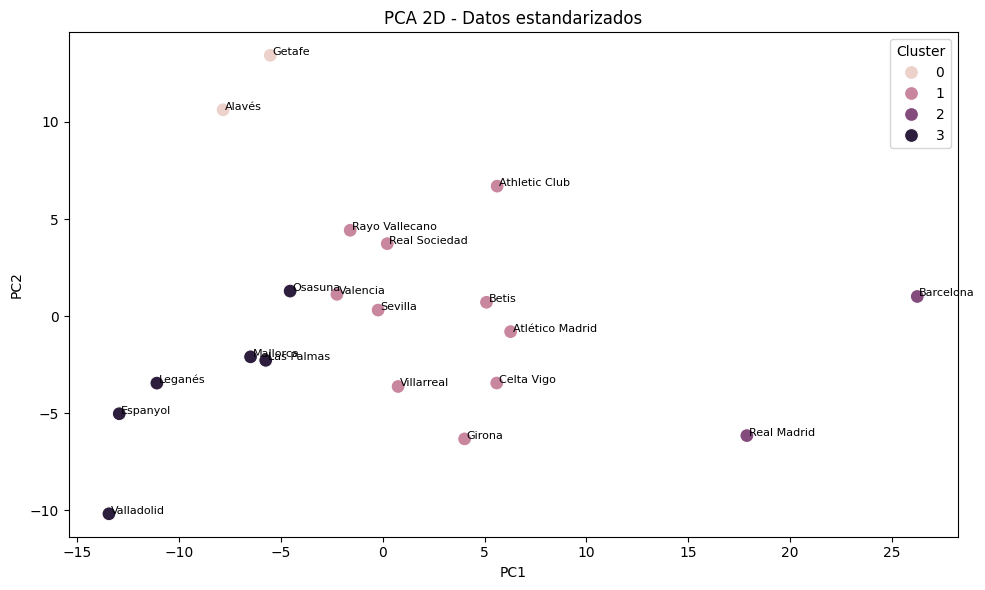

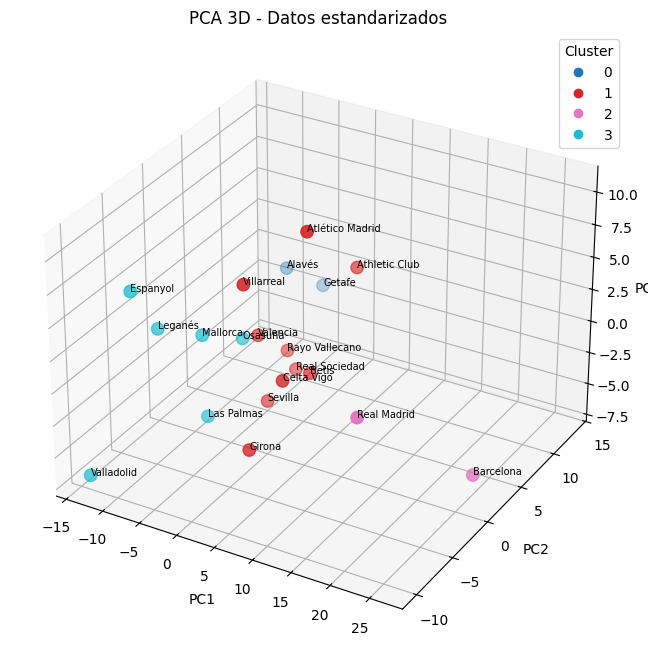

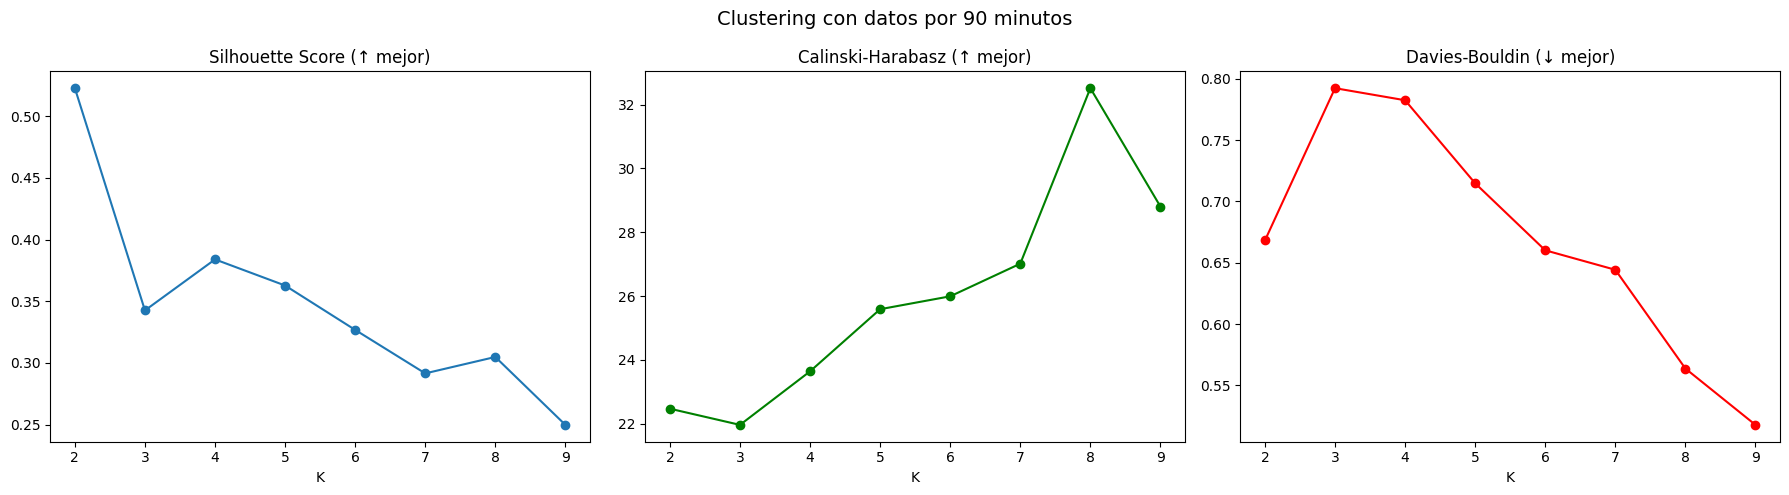

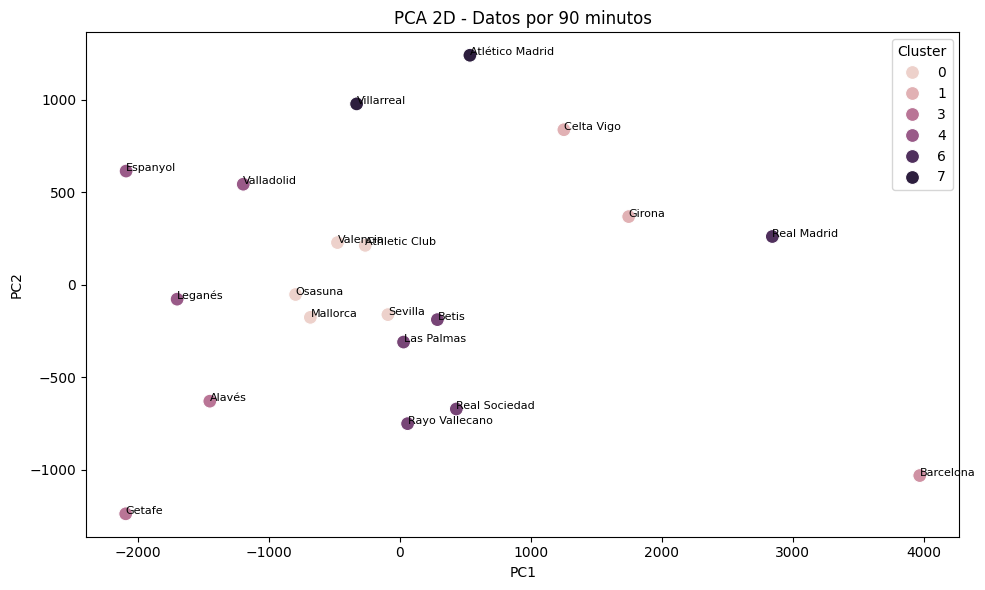

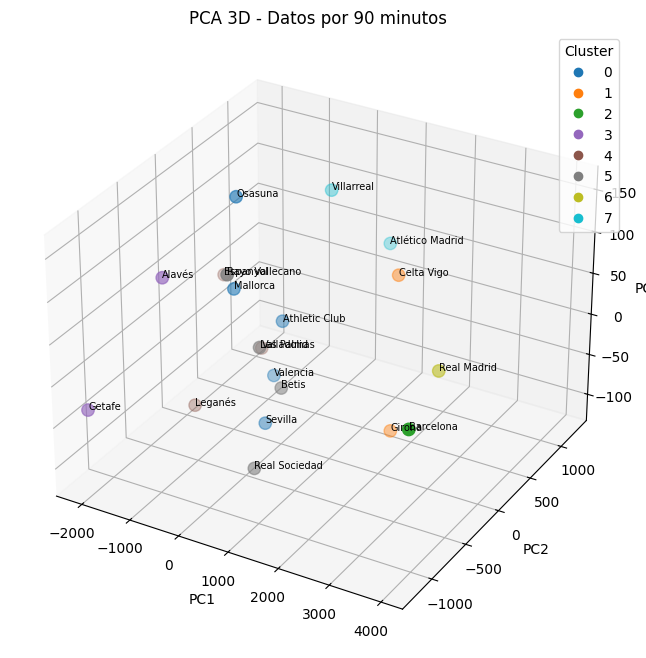

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 1. Función para evaluar clustering
# ================================
def evaluar_clusters(X, rango=range(2, 10), titulo="Evaluación de Clustering"):
    silhouette_scores, calinski_scores, davies_scores = [], [], []

    for k in rango:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        silhouette_scores.append(silhouette_score(X, labels))
        calinski_scores.append(calinski_harabasz_score(X, labels))
        davies_scores.append(davies_bouldin_score(X, labels))

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(rango, silhouette_scores, marker='o')
    axes[0].set_title("Silhouette Score (↑ mejor)")
    axes[0].set_xlabel("K")

    axes[1].plot(rango, calinski_scores, marker='o', color='green')
    axes[1].set_title("Calinski-Harabasz (↑ mejor)")
    axes[1].set_xlabel("K")

    axes[2].plot(rango, davies_scores, marker='o', color='red')
    axes[2].set_title("Davies-Bouldin (↓ mejor)")
    axes[2].set_xlabel("K")

    fig.suptitle(titulo, fontsize=14)
    plt.tight_layout()
    plt.show()

    return silhouette_scores, calinski_scores, davies_scores

# ================================
# 2. Función para visualizar PCA
# ================================
def visualizar_pca(X, labels, nombres, n_components=2, titulo="PCA Clustering"):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])
    df_pca["Cluster"] = labels
    df_pca["Nombre"] = nombres

    if n_components == 2:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Cluster", s=100)
        for i, row in df_pca.iterrows():
            plt.text(row["PC1"]+0.1, row["PC2"], row["Nombre"], fontsize=8)
        plt.title(titulo)
        plt.tight_layout()
        plt.show()

    elif n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        scatter = ax.scatter(df_pca["PC1"], df_pca["PC2"], df_pca["PC3"],
                             c=df_pca["Cluster"], cmap="tab10", s=80)
        for i, row in df_pca.iterrows():
            ax.text(row["PC1"], row["PC2"], row["PC3"], row["Nombre"], fontsize=7)
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
        plt.title(titulo)
        plt.legend(*scatter.legend_elements(), title="Cluster")
        plt.show()

# ================================
# 3. Flujo de trabajo
# ================================
# Cargar datos
df = pd.read_csv("../output/all_teams_all_metrics.csv")
# df = df[df["Season"].isin(["2023-2024","2024-2025"])]  # Ejemplo: varias temporadas
df = df[df['Season'] == '2024-2025']  # Filtrar por temporada específica
# Variables de identificación
equipos = df["Squad"].values

# ---- A) Datos estandarizados (totales)
X_std = StandardScaler().fit_transform(df.select_dtypes(include=[np.number]))

sil_std, ch_std, db_std = evaluar_clusters(X_std, titulo="Clustering con datos estandarizados")

k_opt_std = 4  # Ejemplo: el K que elijas de la evaluación
labels_std = KMeans(n_clusters=k_opt_std, random_state=42, n_init=10).fit_predict(X_std)

visualizar_pca(X_std, labels_std, equipos, n_components=2, titulo="PCA 2D - Datos estandarizados")
visualizar_pca(X_std, labels_std, equipos, n_components=3, titulo="PCA 3D - Datos estandarizados")

# ---- B) Datos por 90 minutos
#X_per90 = df.select_dtypes(include=[np.number]).div(df["MP"], axis=0)  # "MP" = partidos jugados/minutos totales
#X_per90 = StandardScaler().fit_transform(X_per90)

sil_90, ch_90, db_90 = evaluar_clusters(X_90, titulo="Clustering con datos por 90 minutos")

k_opt_90 = 8  # Ejemplo: el K que salga mejor
labels_90 = KMeans(n_clusters=k_opt_90, random_state=42, n_init=10).fit_predict(X_90)

visualizar_pca(X_90, labels_90, equipos, n_components=2, titulo="PCA 2D - Datos por 90 minutos")
visualizar_pca(X_90, labels_90, equipos, n_components=3, titulo="PCA 3D - Datos por 90 minutos")


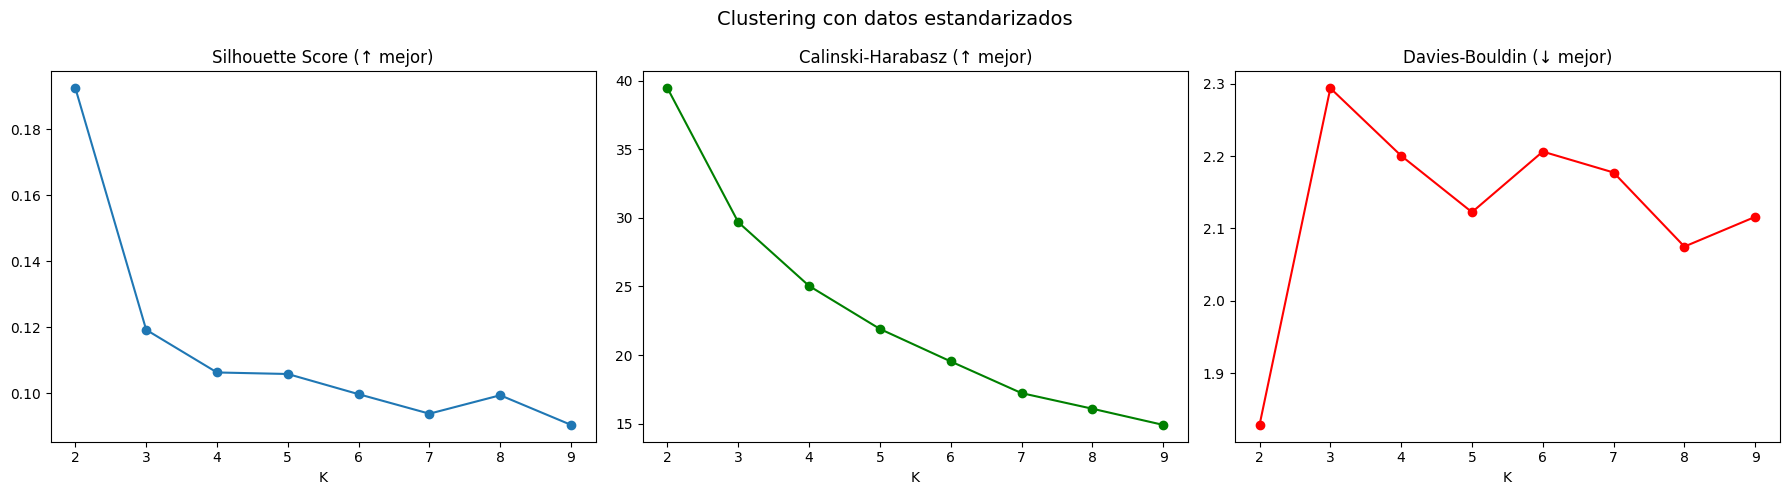

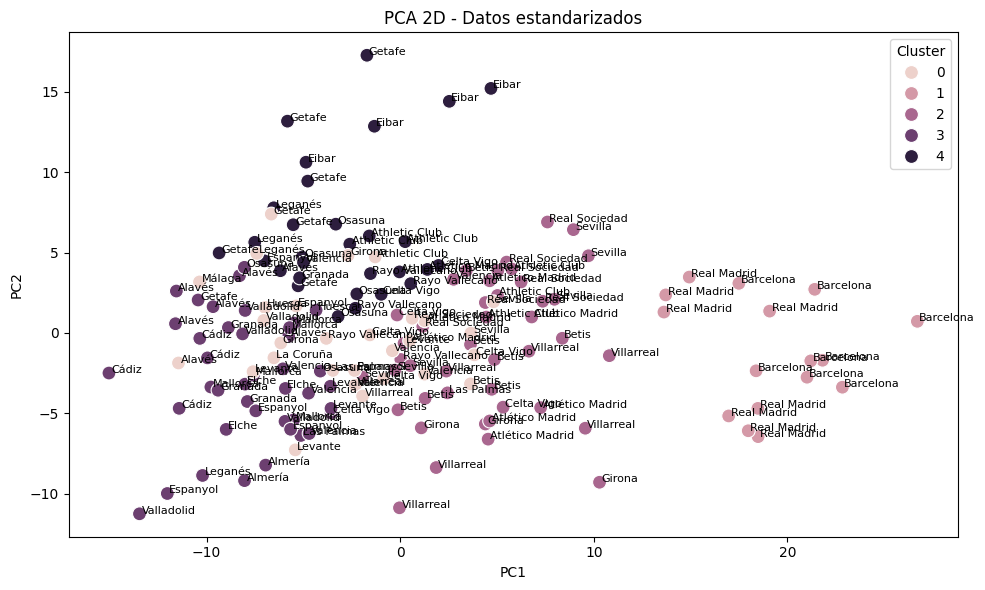

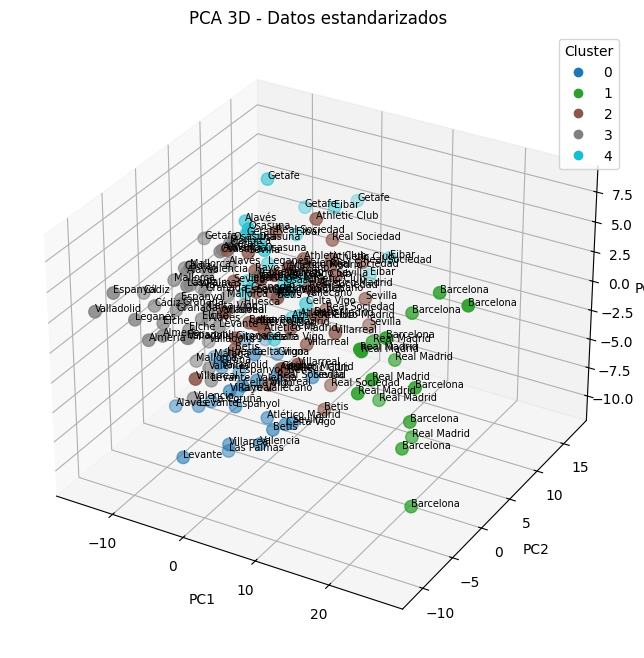

In [11]:
# Cargar datos
df_total = pd.read_csv("../output/all_teams_all_metrics.csv")
# Variables de identificación
equipos = df_total["Squad"].values

# ---- A) Datos estandarizados (totales)
X_std = StandardScaler().fit_transform(df_total.select_dtypes(include=[np.number]))

sil_std, ch_std, db_std = evaluar_clusters(X_std, titulo="Clustering con datos estandarizados")

k_opt_std = 5  # Ejemplo: el K que elijas de la evaluación
labels_std = KMeans(n_clusters=k_opt_std, random_state=42, n_init=10).fit_predict(X_std)

visualizar_pca(X_std, labels_std, equipos, n_components=2, titulo="PCA 2D - Datos estandarizados")
visualizar_pca(X_std, labels_std, equipos, n_components=3, titulo="PCA 3D - Datos estandarizados")


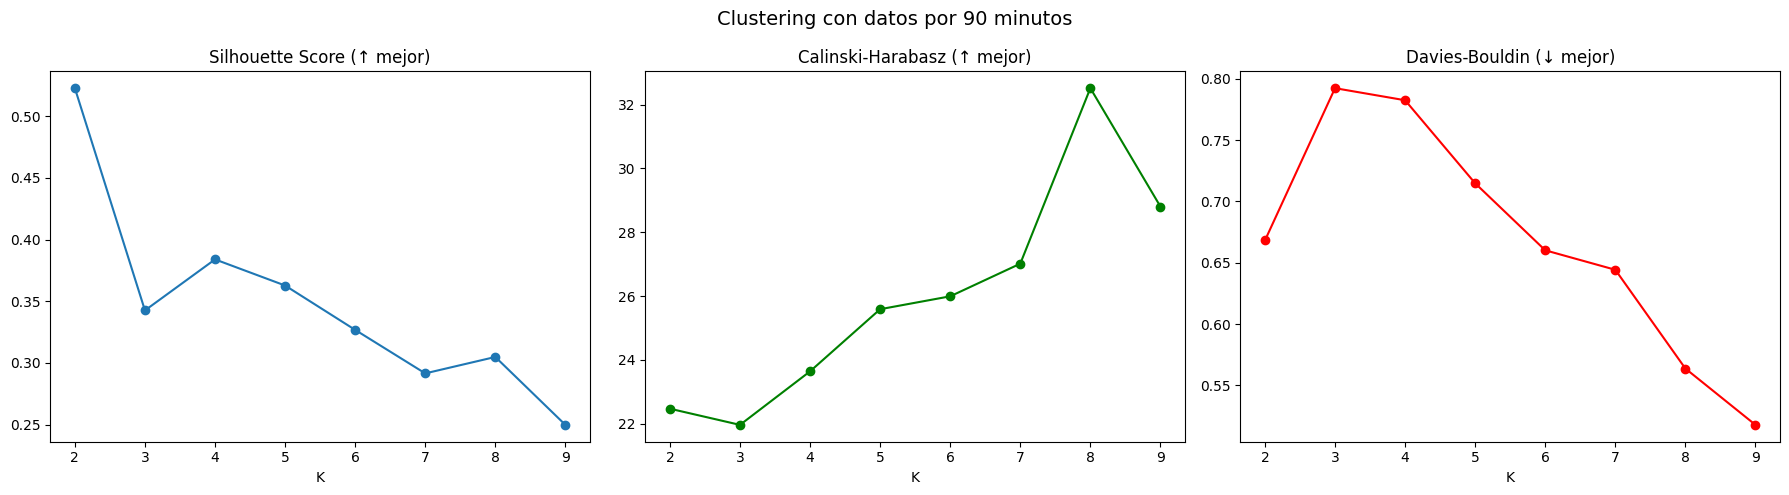

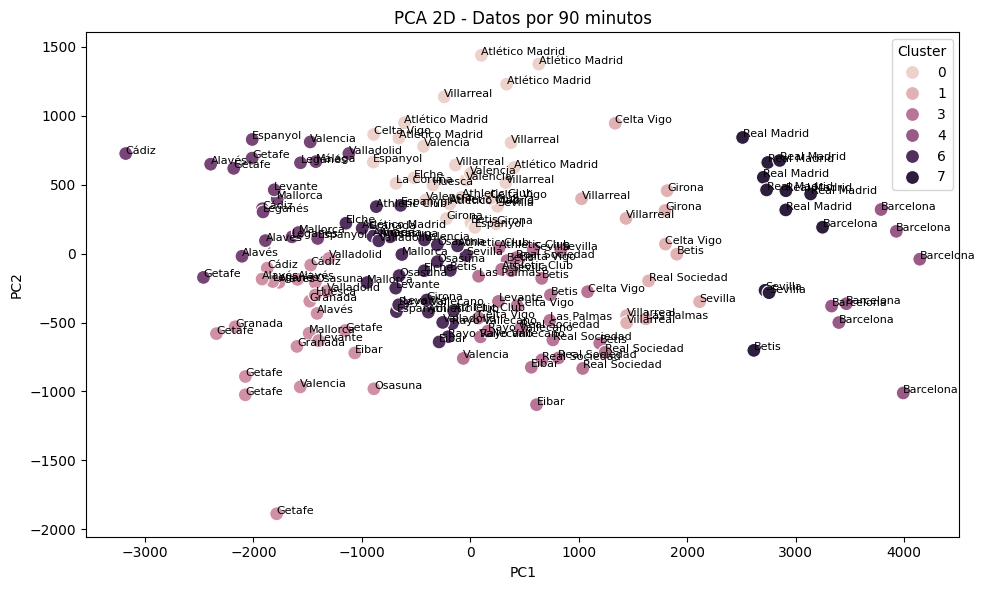

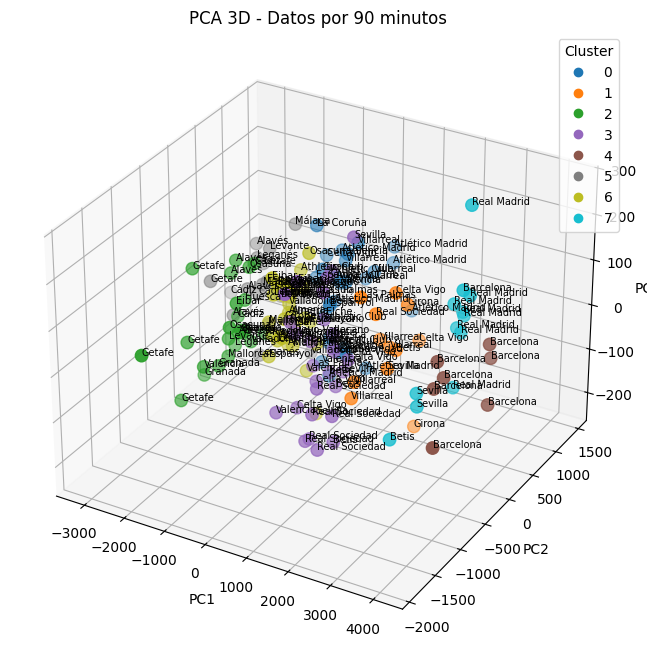

In [12]:
# ---- B) Datos por 90 minutos
X_per90 = df_total.select_dtypes(include=[np.number]).div(38, axis=0)  # "MP" = partidos jugados/minutos totales
sil_90, ch_90, db_90 = evaluar_clusters(X_90, titulo="Clustering con datos por 90 minutos")
equipos_90 = df_total["Squad"].values
k_opt_90 = 8  # Ejemplo: el K que salga mejor
labels_90 = KMeans(n_clusters=k_opt_90, random_state=42, n_init=10).fit_predict(X_per90)

visualizar_pca(X_per90, labels_90, equipos_90, n_components=2, titulo="PCA 2D - Datos por 90 minutos")
visualizar_pca(X_per90, labels_90, equipos_90, n_components=3, titulo="PCA 3D - Datos por 90 minutos")

In [14]:
import plotly.express as px
import pandas as pd

def visualizar_pca_plotly(X, labels, nombres, n_components=2, titulo="PCA Clustering (Interactivo)"):
    """
    Visualiza resultados de PCA en 2D o 3D usando Plotly (interactivo).
    
    Parámetros:
    -----------
    X : array-like
        Matriz de datos transformados (ej. salida de PCA).
    labels : array-like
        Etiquetas de cluster.
    nombres : array-like
        Nombres (ej. equipos).
    n_components : int, default=2
        Número de componentes principales a mostrar (2 o 3).
    titulo : str
        Título de la gráfica.
    """
    
    df_pca = pd.DataFrame(X, columns=[f"PC{i+1}" for i in range(n_components)])
    df_pca["Cluster"] = pd.Categorical(labels)
    df_pca["Nombre"] = nombres

    if n_components == 2:
        fig = px.scatter(
            df_pca,
            x="PC1", y="PC2",
            color="Cluster",
            text="Nombre",  # aparece al hacer hover
            title=titulo,
            symbol="Cluster"
        )
        fig.update_traces(textposition="top center")

    elif n_components == 3:
        fig = px.scatter_3d(
            df_pca,
            x="PC1", y="PC2", z="PC3",
            color="Cluster",
            text="Nombre",
            title=titulo,
            symbol="Cluster"
        )
        fig.update_traces(textposition="top center")

    else:
        raise ValueError("Solo se soporta 2D o 3D (n_components=2 o 3).")

    fig.show()


ModuleNotFoundError: No module named 'plotly'